In [1]:
!pip install pulp
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 84.5 MB/s eta 0:00:00


In [5]:
from pulp import *
from scipy.stats import truncnorm
import numpy as np
import random

def get_truncated_normal(mean, sd, low, upp):
    return truncnorm((low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

def one_hot_encode_airport(airport, num_airports):
    encoding = np.zeros(num_airports)
    encoding[airport] = 1
    return encoding

def generate_info_arv(requests):
    ts_arv = np.empty(shape=(len(requests),), dtype='object')
    start_date_arv = np.empty(shape=(len(requests),), dtype='object')
    for i in range(len(requests)):
        ts_arv[i] = requests[i][1] + requests[i][5]/5
        if ts_arv[i] > 287:
            ts_arv[i] = ts_arv[i] - 287
            start_date_arv[i] = requests[i][2] + 1
        else:
            start_date_arv[i] = requests[i][2]
    return ts_arv, start_date_arv

def get_ts_per_year(ts_slots, dates):
    result = np.empty(shape=(len(ts_slots),), dtype='object')
    for i in range(len(ts_slots)):
        result[i] = dates[i] * 287 + ts_slots[i]
    return result

#Modify the distribution based on historical data later:
def generate_scenario(number_of_requests, num_airports):

    #number_of_requests = 15000
    ts_72 = get_truncated_normal(mean=72, sd=12, low=0, upp=287).rvs(int(round(number_of_requests/2)))
    ts_72 = np.round(ts_72)

    ts_216 = get_truncated_normal(mean=216, sd=12, low=0, upp=287).rvs(int(round(number_of_requests/2)))
    ts_216 = np.round(ts_216)

    ts_dep = np.concatenate((ts_72, ts_216))
    ts_dep = ts_dep.astype(int)

    #Generate index for requests:
    index = np.array(list(range(number_of_requests)))

    origin_airport = np.empty(shape=(number_of_requests,), dtype='object')

    for i in range(number_of_requests):
        #Generate origin (0 and 1 are two considered origin airports, 2 represent other airports, encoded in one-hot vector):
        _org_airport = one_hot_encode_airport(0, num_airports)
        _org_airport_list = _org_airport.tolist()
        origin_airport[i] = _org_airport_list

    # Define requests_full as dtype object
    num_entries = len(index)  # Given that 'index' is defined using np.array(list(range(number_of_requests)))
    # Create an empty array of the desired shape with dtype=object
    requests_full = np.empty((num_entries, 3), dtype=object)

    data = [index, ts_dep, origin_airport]
    for i, column_data in enumerate(data):
        requests_full[:, i] = column_data

    return requests_full

num_airports = 1
number_of_requests = 1000
flight_requests = generate_scenario(number_of_requests, num_airports)
time_slots = 288 # Time slots and their characteristics
capacity_per_slot = 6
max_movements = 6

# Create a MILP problem
problem = LpProblem(name="Flight_Scheduling", sense=LpMinimize)

# Create binary decision variables for each flight request and each possible change in time slots
x = {(req, slot): LpVariable(name=f"x_{req}_{slot}", cat="Binary")
     for req in range(number_of_requests) for slot in range(time_slots)}

# Objective function - minimises the total absolute difference between the requested and allocated time interval
problem += lpSum(x[req, slot] * abs(slot - flight_requests[req][1]) for req in range(number_of_requests) for slot in range(time_slots))

# Constraints -
# checks if a movement is allocated to only 1 timeslot
for req in range(number_of_requests):
    problem += lpSum(x[req, slot] for slot in range(time_slots)) == 1
# excludes checking if movement m operates on day d (for requests that are series)
# checks that the total movements does not exceed capacity for each timeslot
for slot in range(time_slots):
    problem += lpSum(x[req, slot] for req in range(number_of_requests)) <= capacity_per_slot

# optimal solution found for number_of_requests = 700, max_movements = 12
# checks that the change in slot for each request < max_movements
# for req in range(number_of_requests):
#     problem += lpSum(x[req, slot] * abs(slot - flight_requests[req][1]) for slot in range(time_slots)) <= max_movements

# Solve the MILP problem
problem.solve()

updated_slots = []
max_change = float('-inf')
number_unchanged = 0
movements = []

# Iterate through the decision variables and check if they are equal to 1
for req in range(number_of_requests):
    for slot in range(time_slots):
        if x[req, slot].varValue == 1:
            change = abs(flight_requests[req][1] - slot)
            if not change:
                number_unchanged += 1
            if change > max_change:
                max_change = change
            updated_slots.append((req, slot))
            movements.append(abs(flight_requests[req][1] - slot))

# Print the slot changes
for req, slot in updated_slots:
    print(f"Flight Request {req}: Change from dep slot {flight_requests[req][1]} to {slot}")

print("Status:", LpStatus[problem.status])
print(f"{number_unchanged} flight requests out of {number_of_requests} were not shifted.")
print("Maximum Shift:", max_change)
print("Objective Value:", problem.objective.value())

Flight Request 0: Change from dep slot 61 to 57
Flight Request 1: Change from dep slot 66 to 56
Flight Request 2: Change from dep slot 68 to 68
Flight Request 3: Change from dep slot 84 to 99
Flight Request 4: Change from dep slot 54 to 54
Flight Request 5: Change from dep slot 60 to 39
Flight Request 6: Change from dep slot 75 to 108
Flight Request 7: Change from dep slot 65 to 56
Flight Request 8: Change from dep slot 63 to 34
Flight Request 9: Change from dep slot 69 to 32
Flight Request 10: Change from dep slot 77 to 110
Flight Request 11: Change from dep slot 70 to 70
Flight Request 12: Change from dep slot 77 to 77
Flight Request 13: Change from dep slot 73 to 66
Flight Request 14: Change from dep slot 57 to 57
Flight Request 15: Change from dep slot 72 to 47
Flight Request 16: Change from dep slot 66 to 66
Flight Request 17: Change from dep slot 77 to 77
Flight Request 18: Change from dep slot 79 to 104
Flight Request 19: Change from dep slot 81 to 111
Flight Request 20: Change 

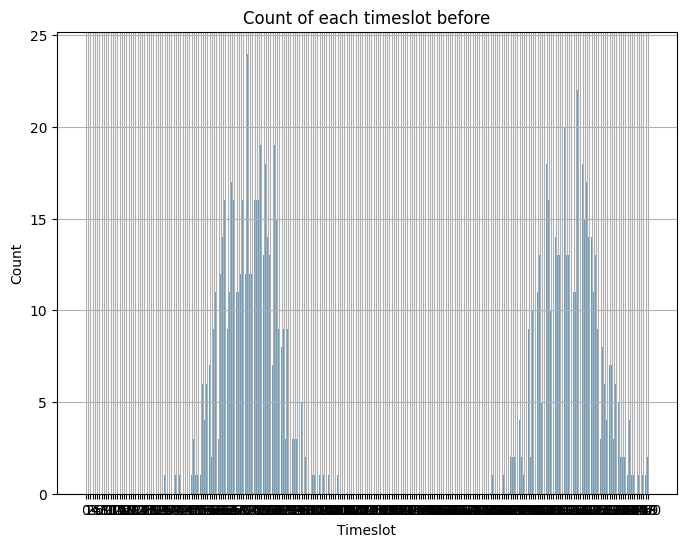

In [7]:
import matplotlib.pyplot as plt

original_slots = [req[1] for req in flight_requests]
# Count occurrences of each slot number
slot_counts = np.bincount(original_slots)

# Create x-axis values (timeslots)
timeslots = np.arange(len(slot_counts))

# Plotting the graph
plt.figure(figsize=(8, 6))
plt.bar(timeslots, slot_counts, align='center', alpha=0.7)
plt.xticks(timeslots)
plt.xlabel('Timeslot')
plt.ylabel('Count')
plt.title('Count of each timeslot before')
plt.grid(True)
plt.show()

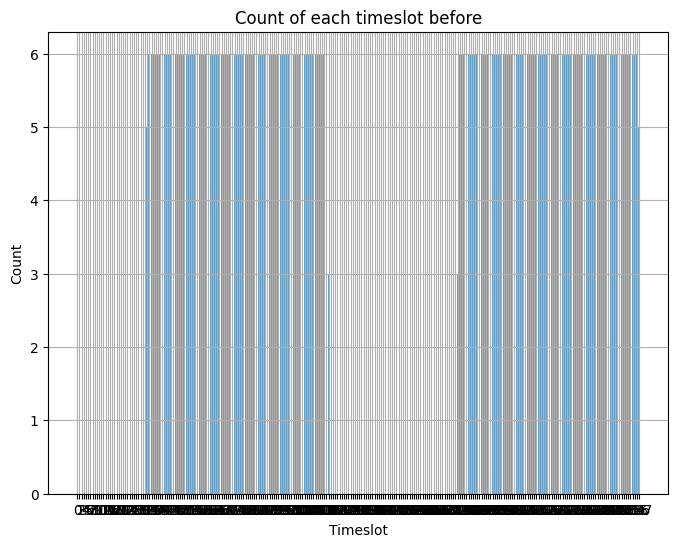

In [8]:
new_slots = [slot for req,slot in updated_slots]
# Count occurrences of each slot number
slot_counts = np.bincount(new_slots)

# Create x-axis values (timeslots)
timeslots = np.arange(len(slot_counts))

# Plotting the graph
plt.figure(figsize=(8, 6))
plt.bar(timeslots, slot_counts, align='center', alpha=0.7)
plt.xticks(timeslots)
plt.xlabel('Timeslot')
plt.ylabel('Count')
plt.title('Count of each timeslot before')
plt.grid(True)
plt.show()